###### The probability of an eccentricity GIVEN that a planet is transiting (P(e|b)) and the probability of a longitude of periastron GIVEN that a planet is transiting (P(w|b)) are different than P(e) and P(w).

https://academic.oup.com/mnras/article/444/3/2263/1053015

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
from scipy.stats import rayleigh
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# UNIFORM DISTRIBUTION

In [206]:
trueew_uniform = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/uniform/fnames.txt', index_col=False)

truee_uniform = np.array(trueew_uniform['true_e'])
truew_uniform = np.array(trueew_uniform['true_w'])

distpath_uniform = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/uniform/edists/"
zscpath_uniform = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/uniform/zscores/"

edist_uniform = []
zsc_uniform = []

for file in os.listdir(distpath_uniform):
    fname = os.path.join(distpath_uniform, file)
    try:
        edist_uniform.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass
    

for file in os.listdir(zscpath_uniform):
    fname = os.path.join(zscpath_uniform, file)
    try:
        zsc_uniform.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass

es_uniform = []
ws_uniform = []
gs_uniform = []

zsc_e_uniform = []
zsc_w_uniform = []


for i in range(len(edist_uniform)):
    try:
        es_uniform.append(edist_uniform[i][:,0])
        ws_uniform.append(edist_uniform[i][:,1])
        gs_uniform.append(edist_uniform[i][:,2])
        
        zsc_e_uniform.append(zsc_uniform[i][0])
        zsc_w_uniform.append(zsc_uniform[i][1])
        
    except IndexError:
        truee_uniform = np.delete(truee_uniform, i)
        truew_uniform = np.delete(truew_uniform, i)
    

es_mode_uniform = []
ws_mode_uniform = []
gs_mode_uniform = []

for i in range(len(es_uniform)):
    es_mode_uniform.append(ph.mode(es_uniform[i]))
    ws_mode_uniform.append(ph.mode(ws_uniform[i]))
    gs_mode_uniform.append(ph.mode(gs_uniform[i]))
    

zsc_means_uniform = []

for i in range(len(zsc_e_uniform)):
    zsc_means_uniform.append(np.mean((zsc_e_uniform[i], zsc_w_uniform[i])))

#plt.scatter(truee, truew, c=np.abs(zsc_means), cmap='Blues_r')
#plt.colorbar()

<ipython-input-206-3c3086895445>:15: UserWarning: genfromtxt: Empty input file: "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/uniform/edists/e_0.7016680685355956_w_-59.26857908763873_distributions.csv"
  edist_uniform.append(np.genfromtxt(fname, delimiter=','))


(array([25., 12., 19., 22., 18., 20., 24., 26., 21., 25.]),
 array([3.67066624e-04, 1.00144795e-01, 1.99922524e-01, 2.99700252e-01,
        3.99477981e-01, 4.99255710e-01, 5.99033438e-01, 6.98811167e-01,
        7.98588895e-01, 8.98366624e-01, 9.98144352e-01]),
 <BarContainer object of 10 artists>)

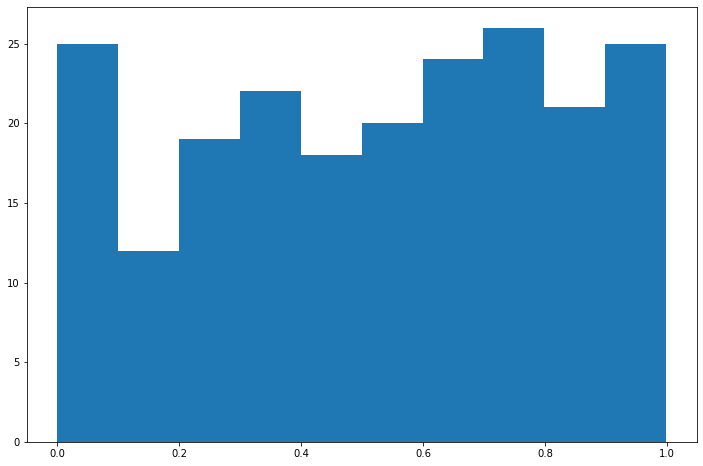

In [226]:
plt.hist(truee_uniform)

Text(0.5, 0, 'Fit E Distributions')

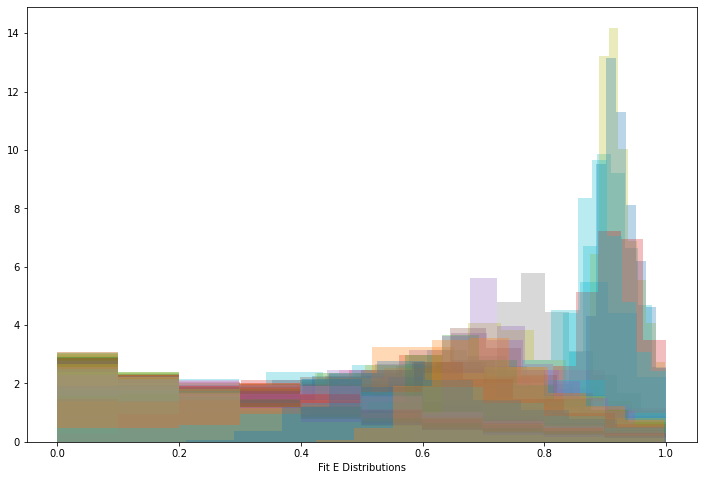

In [207]:
es_uniform = np.array(es_uniform)

plt.cla()

for i in range(len(es_uniform)):
    plt.hist(es_uniform[i], alpha=0.3, density=1.0)
    
plt.xlabel('Fit E Distributions')

Text(0.5, 0, 'Fit w Distributions')

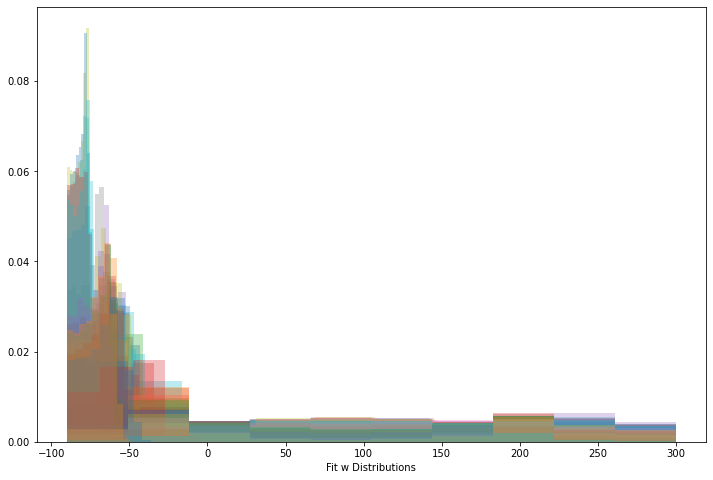

In [208]:
ws_uniform = np.array(ws_uniform)

plt.cla()

for i in range(len(es_uniform)):
    plt.hist(ws_uniform[i], alpha=0.3, density=1.0)
    
plt.xlabel('Fit w Distributions')

In [209]:
alles_uniform = es_uniform.flatten()
allws_uniform = ws_uniform.flatten()

Text(0, 0.5, 'ECCENTRICITY')

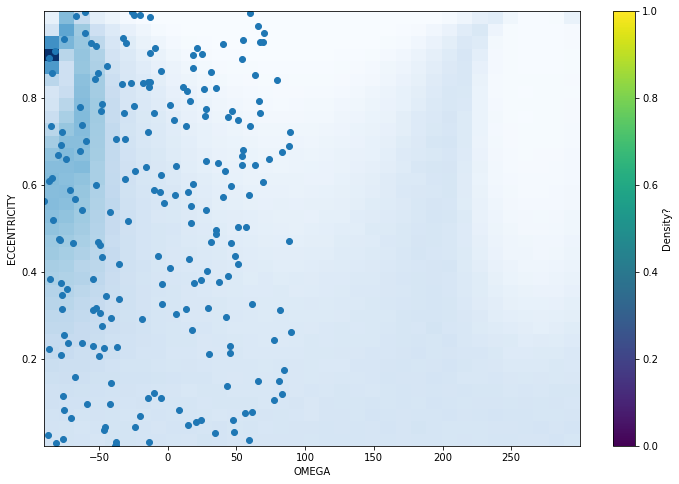

In [228]:
plt.cla()

plt.hist2d(allws_uniform, alles_uniform, bins=35, cmap='Blues');
plt.scatter(truew_uniform, truee_uniform, cmap='Blues')
plt.clim(vmax=5000.0)
plt.colorbar(label='Density?')

plt.xlabel('OMEGA')
plt.ylabel('ECCENTRICITY')

# GAUSSIAN DISTRIBUTION

In [219]:
# e_rand = np.random.normal(0.4, 0.1, size=n)
# w_rand = np.random.normal(0.0, 45.0, size=n)

In [230]:
trueew_gauss = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/gaussian/fnames.txt', index_col=False)

truee_gauss = np.array(trueew_gauss['true_e'])
truew_gauss = np.array(trueew_gauss['true_w'])

distpath_gauss = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/gaussian/edists/"
zscpath_gauss = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/results/gaussian/zscores/"

edist_gauss = []
zsc_gauss = []

for file in os.listdir(distpath_gauss):
    fname = os.path.join(distpath_gauss, file)
    try:
        edist_gauss.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass
    

for file in os.listdir(zscpath_gauss):
    fname = os.path.join(zscpath_gauss, file)
    try:
        zsc_gauss.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass

es_gauss = []
ws_gauss = []
gs_gauss = []

zsc_e_gauss = []
zsc_w_gauss = []

for i in range(len(edist_gauss)):
    try:
        es_gauss.append(edist_gauss[i][:,0])
        ws_gauss.append(edist_gauss[i][:,1])
        gs_gauss.append(edist_gauss[i][:,2])
        
        zsc_e_gauss.append(zsc_gauss[i][0])
        zsc_w_gauss.append(zsc_gauss[i][1])
        
    except IndexError:
        truee = np.delete(truee_gauss, i)
        truew = np.delete(truew_gauss, i)
    

es_mode_gauss = []
ws_mode_gauss = []
gs_mode_gauss = []

for i in range(len(es_gauss)):
    es_mode_gauss.append(ph.mode(es_gauss[i]))
    ws_mode_gauss.append(ph.mode(ws_gauss[i]))
    gs_mode_gauss.append(ph.mode(gs_gauss[i]))
    

zsc_means_gauss = []

for i in range(len(zsc_e_gauss)):
    zsc_means_gauss.append(np.mean((zsc_e_gauss[i], zsc_w_gauss[i])))

#plt.scatter(truee, truew, c=np.abs(zsc_means), cmap='Blues_r')
#plt.colorbar()

Text(0.5, 0, 'Fit E Distributions')

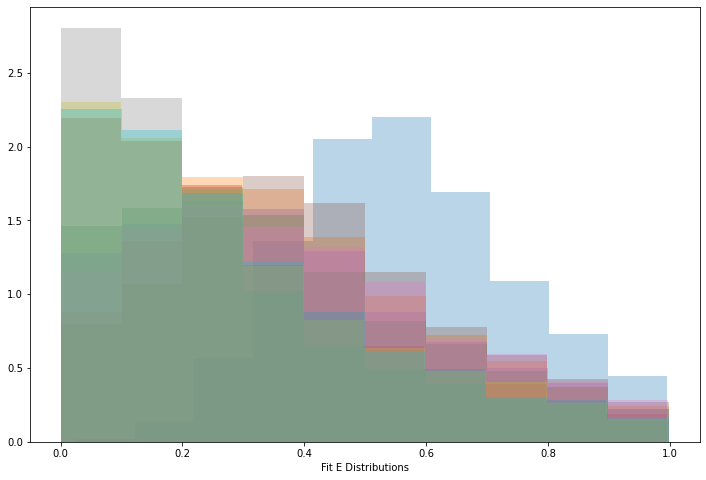

In [231]:
es_gauss = np.array(es_gauss)

plt.cla()

for i in range(len(es_gauss)):
    plt.hist(es_gauss[i], alpha=0.3, density=1.0)
    
plt.xlabel('Fit E Distributions')

Text(0.5, 0, 'Fit w Distributions')

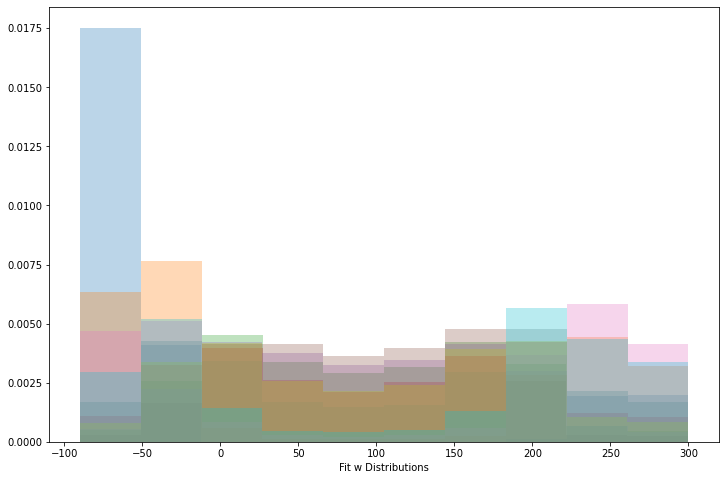

In [232]:
ws_gauss = np.array(ws_gauss)

plt.cla()

for i in range(len(ws_gauss)):
    plt.hist(ws_gauss[i], alpha=0.3, density=1.0)
    
plt.xlabel('Fit w Distributions')

In [233]:
alles_gauss = es_gauss.flatten()
allws_gauss = ws_gauss.flatten()

Text(0, 0.5, 'ECCENTRICITY')

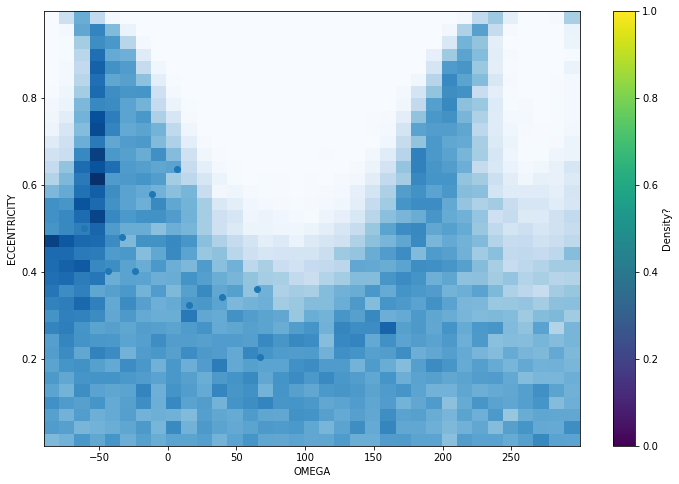

In [235]:
plt.cla()

plt.hist2d(allws_gauss, alles_gauss, bins=35, cmap='Blues');
plt.scatter(truew_gauss, truee_gauss)
#plt.clim(vmax=5000.0)
plt.colorbar(label='Density?')

plt.xlabel('OMEGA')
plt.ylabel('ECCENTRICITY')